# Loads the processed h5 file and plots data

debugging: the pump probe signal looks weird after implementing mpi

In [10]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import sys

sys.path.insert(0, '../src/')
from data_analysis import *
from integrators import *
from analysis import *
from pedestals import *
from h5_handling import *

In [11]:
# input parameters
run_num = 158

# constants
detector_distance = 0.12 # m
energy = 9.5 # keV

# hit finders parameters
iq_thr = 0.8 # photon/pix/i0
r_min, r_max = 20,30 # bins

### load and analyse data

In [12]:
# load data
run = discover_run_h5(run_num)[3:-3]
img,Iq,r,nshots,img_hits,thr,nhits,i0,laser_i0,laser_on,event_ID = load_processed_data(run)

# convert q_scale
q = q_scale(r,detector_distance=detector_distance,photon_energy=energy*1000)

# convert intensity to photon/pix
#img/=energy
Iq /=energy
i0 /=energy

# normalise to i0
Iq_norm = np.zeros(Iq.shape)
i0_avg = np.average(i0)
norm = i0/i0_avg
for i in range(int(nshots)):
    Iq_norm[i]=Iq[i]/norm[i]
    
# hits
metric,hits = find_hits(Iq_norm,threshold=iq_thr)
hit_rate =len(hits[hits>0])/nshots

# water hits
filter_length = 1
ice_thr = 1.0 # delta photon/pix/i0
q_min, q_max = 1.0,4.5 # A-1
ice_metric, ice_hits = find_ice(Iq_norm[:], q, threshold=ice_thr, 
                                filter_length=filter_length, q_min=q_min, q_max=q_max)

hits *= np.logical_not(ice_hits)
print(ice_hits)
print(ice_metric)

# pump probe
hit_avg,miss_avg,diff_signal =  pump_probe_signal(Iq,hits,laser_on)

run0158_droplets_10um_70mm: 18000 shots
[False False False ..., False False False]
[ 0.01029663  0.0105837   0.01069424 ...,  0.01120267  0.01091256
  0.00927636]


<IPython.core.display.Javascript object>


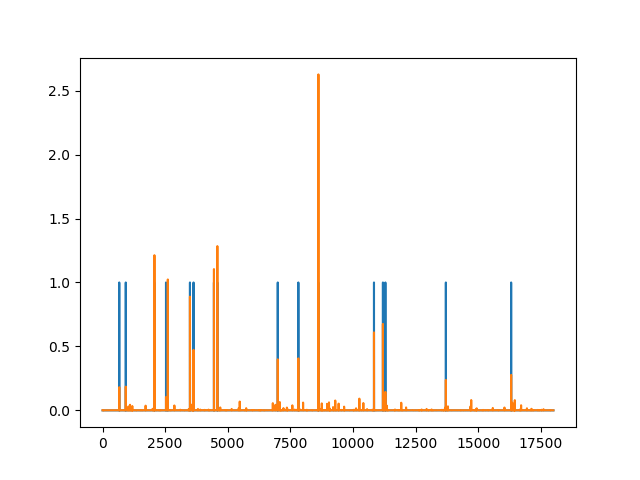

[False False False ..., False False False]
[False False False ..., False False False]


In [13]:
plt.figure()
plt.plot(ice_hits)
plt.plot(ice_metric / 10.0)
plt.show()
print(hits)
print(ice_hits)

<IPython.core.display.Javascript object>


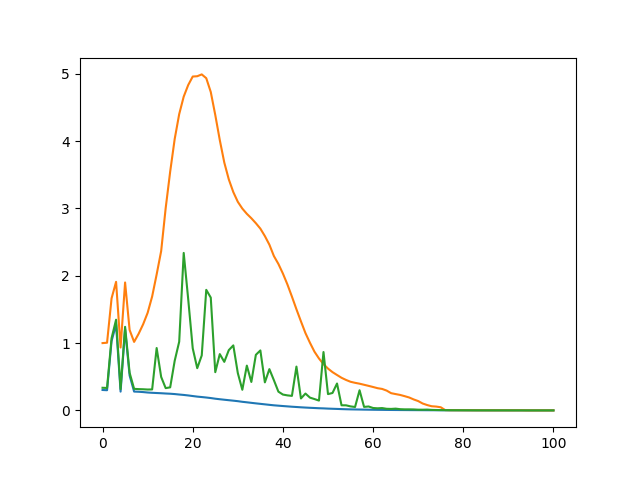

In [14]:
plt.figure()
plt.plot(Iq_norm.mean(0))
plt.plot(Iq_norm[hits].mean(0))
plt.plot(Iq_norm[ice_hits].mean(0))
plt.show()

### plot

<IPython.core.display.Javascript object>


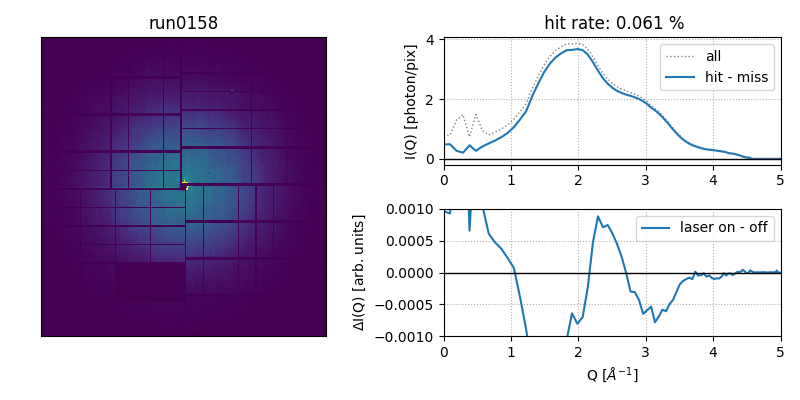

In [15]:
plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.title('run%s'%run[:4])
plt.imshow(img/nshots,clim=[0,.6],origin='lower')
plt.xticks([],'')
plt.yticks([],'')
plt.tight_layout()

plt.subplot(2,2,2)
plt.title(' hit rate: %.3f %%'%(hit_rate*1e2))

plt.plot(q, hit_avg,':',c='gray' ,lw=1,label='all')
plt.plot(q, hit_avg - miss_avg, label='hit - miss')

plt.ylabel('I(Q) [photon/pix]')
plt.legend(loc='upper right')
plt.axhline(0,c='black',lw=1)

plt.xlim(0,5)
plt.grid(linestyle='dotted')

ax = plt.subplot(2,2,4)
ax.plot(q, diff_signal, label='laser on - off')
#ax.fill_between(q, -diff_error, diff_error, alpha=0.3)
plt.ylabel('$\Delta$I(Q) [arb. units]')
plt.ylim([-1e-3,1e-3])#plt.figure()
plt.xlabel('Q [$\AA^{-1}$]')
plt.legend()
plt.xlim(0,5)
plt.grid(linestyle='dotted')
plt.axhline(0,c='black',lw=1)

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


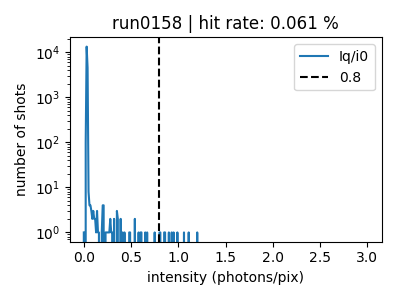

In [16]:
plt.figure(figsize=[4,3])

x,y = do_histogram(metric,0,3,.01)
plt.plot(x,y)
plt.axvline(x=iq_thr,c='black',ls='--')
plt.legend(['Iq/i0',iq_thr])
plt.ylabel('number of shots')
plt.yscale('log',nonposy='clip')
plt.xlabel('intensity (photons/pix)')
plt.title('run%s | hit rate: %.3f %%'%(run[:4],hit_rate*100))
plt.tight_layout()

plt.show()
